In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rasterio, glob
import contextily as cxt

# Datos necesarios
* Población a nivel de AGEBs 2020 **Listo**
* Red carretera **Listo**
* Ubicación geográfica de fuentes puntuales de emisión
* Continuo de Elevaciones Mexicano **Listo**
* Emisiones de Partículas PM2.5 de fuentes puntuales, de área y móviles a nivel 
de celda

# Reclasificación AGEBS con población

In [2]:
agebs_colima = gpd.read_file("data/06_colima/06a.shp")
agebs_colima = agebs_colima[["CVEGEO", "geometry"]]
# transformar a crs 3857
agebs_colima = agebs_colima.to_crs(epsg=3857)

agebs_colima.head()

,CVEGEO,geometry
0,0600100010081,"POLYGON ((-11573376.851 2148017.279, -11573375..."
1,060010001019A,"POLYGON ((-11573031.694 2148092.861, -11573026..."
2,0600100010359,"POLYGON ((-11574163.143 2148511.303, -11574168..."
3,0600100010151,"POLYGON ((-11573464.384 2148548.028, -11573443..."
4,0600100010166,"POLYGON ((-11572109.119 2147990.425, -11572108..."


In [3]:
pop2020 = pd.read_excel("data/IM/IMU_2020.xls", sheet_name="IMU_2020")
pop_colima = pop2020[pop2020["ENT"] == 6]
pop_colima = pop_colima[['CVE_AGEB', 'ENT', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC','AGEB', 'POB_TOTAL', 'GM_2020']]

In [4]:
agebs_pop = agebs_colima.merge(pop_colima, left_on="CVEGEO", right_on="CVE_AGEB")

# reclassify column POB_TOTAL in 10 classes, from 1 to 10 with beautiful labels
agebs_pop["pop"] = pd.qcut(agebs_pop["POB_TOTAL"], 10, labels=range(1,11))

# show range of POB_TOTAL values for each class
ranges = agebs_pop["POB_TOTAL"].groupby(agebs_pop["pop"]).describe()

ranges.reset_index(inplace=True)

ranges["range"] = ranges["min"].astype(str) + " - " + ranges["max"].astype(str)
ranges = ranges[["pop", "range", "min"]]

In [5]:
agebs_pop = gpd.GeoDataFrame(agebs_pop.merge(ranges, on="pop"))
agebs_pop['pop'] = agebs_pop['pop'].astype(int)
agebs_pop.sort_values(by="pop", inplace=True)
agebs_pop.head()

,CVEGEO,geometry,CVE_AGEB,ENT,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,POB_TOTAL,GM_2020,pop,range,min
249,0600100010344,"POLYGON ((-11574181.080 2148545.521, -11574172...",0600100010344,6,Colima,1,Armería,1,Ciudad de Armería,0344,109,Alto,1,56.0 - 234.0,56.0
277,0600700010973,"POLYGON ((-11614328.950 2168738.474, -11614450...",0600700010973,6,Colima,7,Manzanillo,1,Manzanillo,0973,121,Alto,1,56.0 - 234.0,56.0
278,060070001169A,"POLYGON ((-11611315.388 2167465.794, -11611333...",060070001169A,6,Colima,7,Manzanillo,1,Manzanillo,169A,91,Muy bajo,1,56.0 - 234.0,56.0
279,0600700010831,"POLYGON ((-11617234.784 2171001.445, -11617211...",0600700010831,6,Colima,7,Manzanillo,1,Manzanillo,0831,149,Alto,1,56.0 - 234.0,56.0
280,060090001086A,"POLYGON ((-11564761.290 2148322.405, -11564730...",060090001086A,6,Colima,9,Tecomán,1,Tecomán,086A,217,Bajo,1,56.0 - 234.0,56.0


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


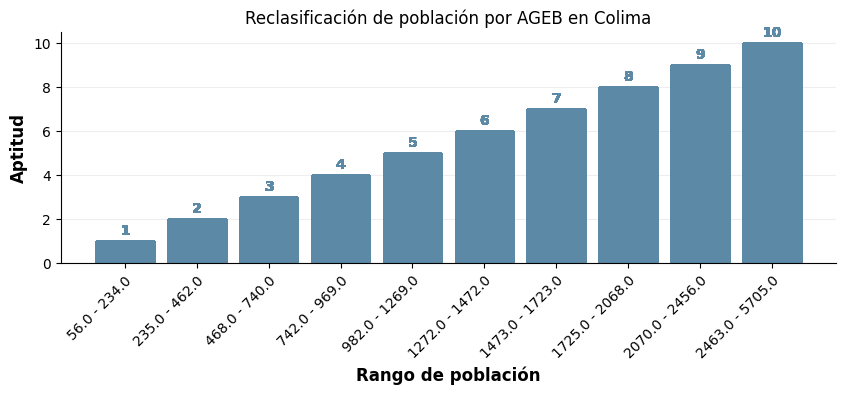

In [6]:
fig, ax = plt.subplots( figsize=(10,3))
plt.rc('font', family='Open Sans')

bars = ax.bar(x=agebs_pop["range"], height=agebs_pop["pop"], color="#5B89A6")

# Add text annotations to the top of the bars.
# round corners of bars

bar_color = bars[0].get_facecolor()
for bar in bars:
  bar.set_edgecolor(bar_color)
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# rotate xtick labels 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Reclasificación de población por AGEB en Colima")
ax.set_xlabel("Rango de población", fontsize=12, fontweight="bold")
ax.set_ylabel("Aptitud", fontsize=12, fontweight="bold")
sns.despine()

plt.show()

In [7]:

agebs_pop = agebs_pop[["CVEGEO", "geometry", "pop"]]
agebs_pop.head()

,CVEGEO,geometry,pop
249,0600100010344,"POLYGON ((-11574181.080 2148545.521, -11574172...",1
277,0600700010973,"POLYGON ((-11614328.950 2168738.474, -11614450...",1
278,060070001169A,"POLYGON ((-11611315.388 2167465.794, -11611333...",1
279,0600700010831,"POLYGON ((-11617234.784 2171001.445, -11617211...",1
280,060090001086A,"POLYGON ((-11564761.290 2148322.405, -11564730...",1


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

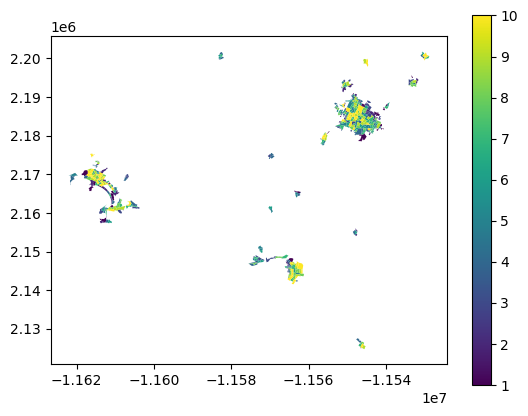

In [8]:
agebs_pop.plot(column="pop", legend=True)

# Emisores puntuales

In [9]:
emisores = pd.read_excel("data/RETC_2004-2020/raw/retc 2020.xlsx", sheet_name="Datos Generales")
emisores = emisores[emisores["ESTADO"] == "COLIMA"]
# drop diplicate rows based on colimn "NOMBRE" and "NRA"
emisores.drop_duplicates(subset=["NOMBRE", "NRA"], inplace=True)

emisores.columns = emisores.columns.str.lower()
# drop columns with more than 80% of null values
emisores.dropna(axis=1, thresh=0.8*len(emisores), inplace=True)

# drop row with duplicate values in column "coordenada\nutm x" and "coordenada\nutm y"
emisores.drop_duplicates(subset=["coordenada\nutm x", "coordenada\nutm y"], inplace=True)

In [10]:
import re
lat = '''104°19'6"'''

def angleString(angle):
    deg, minutes, seconds, direction =  re.split('[°\'"]+', angle)
    return (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
  

In [11]:
emisores["lon"] = emisores["longitud \noeste"].map(angleString)*-1
emisores["lat"] = emisores["latitud norte"].map(angleString)

In [12]:
# make all values in dataframe lowercase
emisores = emisores.applymap(lambda s:s.lower() if type(s) == str else s)

# generate a GeoDataFrame from emisores dataframe and transform to crs 3857

gdf_emisores = gpd.GeoDataFrame(emisores, geometry=gpd.points_from_xy(emisores["lon"], emisores["lat"]), crs="EPSG:4326")
gdf_emisores = gdf_emisores.to_crs(epsg=3857)
gdf_emisores.head()

,nra,nombre,scian,descripción scian,sector,clave\nambiental,subsector,principal actividad productiva,coordenada\nutm x,coordenada\nutm y,...,núm. ext,núm. int,colonia,localidad,estado,municipio,c.p.,lon,lat,geometry
645,cfead0600721,"comisión federal de electricidad,comision fede...",221110,"generación, transmisión y distribución de ener...",generación de energia electrica,ad,generacion y transmision de energia electrica,generación de energía electrica,571722.2798,2.103459e+06,...,s/n,s/n,colonia ejido de campos,manzanillo,colima,manzanillo,28809,-104.318333,19.022500,POINT (-11612663.747 2157585.105)
649,cfem90600711,"comisión federal de electricidad,terminal de g...",493111,almacenes generales de depósito,petroleo y petroquimica,m9,almacenamiento y distribucion de productos der...,otros servicios de almacenamiento con instalac...,577962.4898,2.102091e+06,...,s/n,,colonia campos,manzanillo,colima,manzanillo,28809,-104.259167,19.009722,POINT (-11606077.344 2156080.583)
713,cmb0600800009,consorcio minero benito juarez peña colorada s...,212210,minería de hierro,metalurgica (incluye la siderurgica),11,mineria de hierro,"exploración, explotación y beneficio de minera...",595263.3485,2.143837e+06,...,s/n,,colonia minatitlan,minatitlan,colima,minatitlan,28750,-104.092778,19.386389,POINT (-11587555.017 2200480.190)
714,cmb110600711,consorcio minero benito juarez peña colorada s...,212210,minería de hierro,metalurgica (incluye la siderurgica),11,mineria de hierro,"exploración, explotación y beneficio de minera...",575513.9065,2.110125e+06,...,1000,,colonia tapeixtles,manzanillo,colima,manzanillo,28876,-104.281944,19.082500,POINT (-11608612.954 2164651.365)
721,cma0600700006,"contecon manzanillo s.a. de c.v.,contecon manz...",493190,otros servicios de almacenamiento con instalac...,otros,zu,"almacen de materiales, productos y otros",terminal porturia de uso público especializada...,573219.9348,2.110144e+06,...,s/n,,puerto 1a sección tec ii zona norte,manzanillo,colima,manzanillo,28210,-104.303889,19.082778,POINT (-11611055.799 2164684.085)


In [13]:
# save to gpkg file
gdf_emisores.to_file("data/RETC_2004-2020/retc_2020.gpkg", driver="GPKG")

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


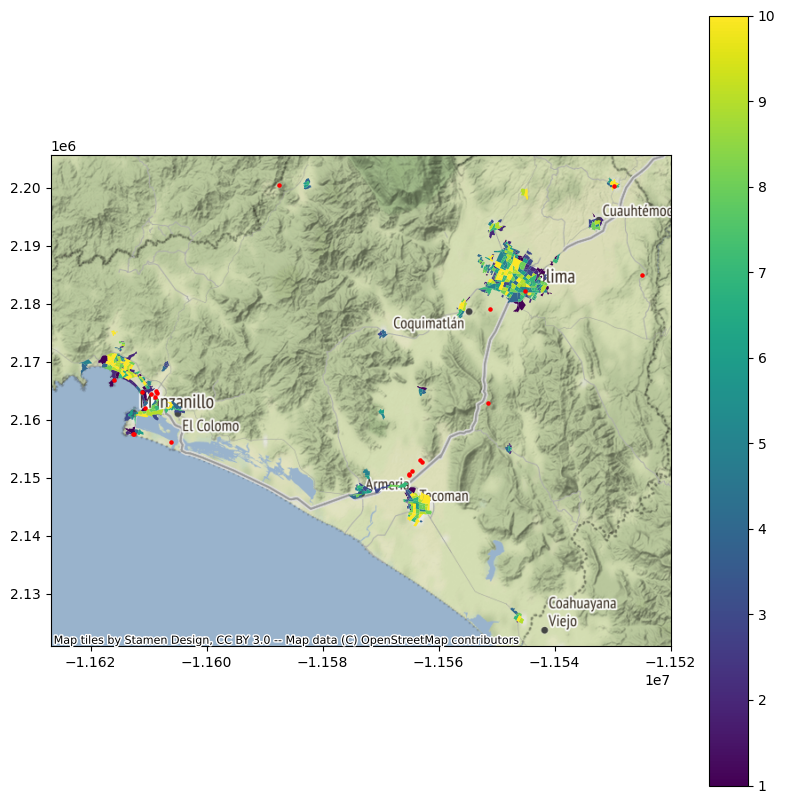

In [14]:
# plot gdf_emisores with basemap
fig, ax = plt.subplots(figsize=(10,10))

agebs_pop.plot(ax=ax, column="pop", legend=True)

gdf_emisores.plot(ax=ax, color="red", markersize=5)

# add basemap
cxt.add_basemap(ax)
plt.show()


## Regiones tentativas

In [15]:
poi = gpd.read_file("data/zonas_tentativas/ZonasTentativas.shp")
# reproject to EPSG:3857
poi = poi.to_crs("EPSG:3857")
poi

DriverError: data/zonas_tentativas/ZonasTentativas.shp: No such file or directory

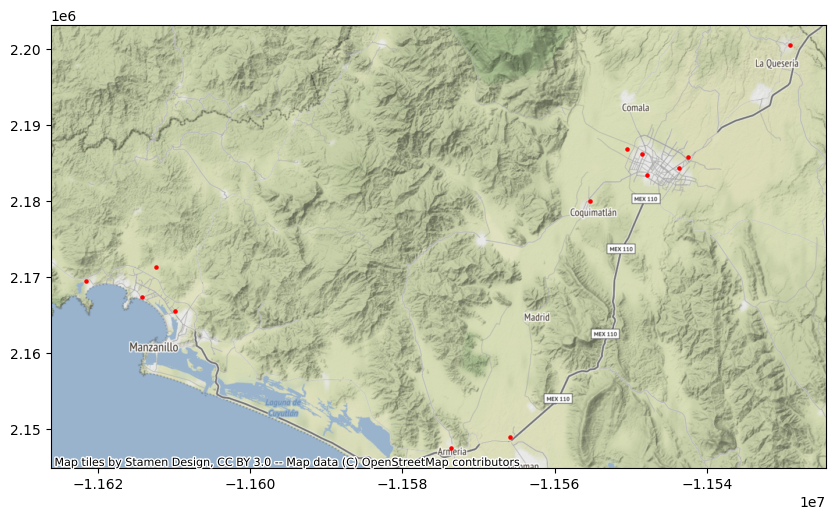

In [ ]:
# plot gdf_emisores with basemap
fig, ax = plt.subplots(figsize=(10,10))

#agebs_pop.plot(ax=ax, column="pop", legend=True)

poi.plot(ax=ax, color="red", markersize=5)

# add basemap
cxt.add_basemap(ax)
plt.show()

In [ ]:
agebs_pop.head()

# join poi with agebs_pop 
poi_agebs = gpd.sjoin(poi, agebs_pop, how="left", op="intersects")
poi_agebs.rename(columns={"pop":"aptitud_densidad"}, inplace=True)
poi_agebs

C:\Users\pedro\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id,Lugar,geometry,index_right,CVEGEO,aptitud_densidad
0,1,UTEM,POINT (-11612417.240 2171359.647),376.0,0600700011740,2.0
1,2,Campus El Naranjo UDC,POINT (-11621600.786 2169531.808),NaN,NaN,NaN
2,3,Campus Tecomán UDC,POINT (-11565874.664 2148973.488),130.0,0600900110408,7.0
3,4,Campus Coquimatlán UDC,POINT (-11555337.163 2179990.718),413.0,0600400010100,9.0
4,5,Campus central UDC,POINT (-11543729.727 2184312.478),109.0,0600200010021,7.0
5,5,Campus Norte UDC,POINT (-11542489.380 2185787.044),251.0,0600200011388,1.0
6,6,Campus Villa de Álvarez UDC,POINT (-11548530.040 2186151.989),187.0,0601000011318,5.0
7,7,IMSS 17,POINT (-11609880.199 2165553.681),24.0,0600700010564,6.0
8,8,IMSS 10,POINT (-11614177.166 2167416.543),121.0,0600700011543,7.0
9,9,IMSS 1,POINT (-11550538.533 2186776.443),398.0,0601000011163,2.0


## Ejes de vialidades

In [ ]:
vialidades = gpd.read_file("data/06_colima/06e.shp")
vialidades = vialidades.to_crs("EPSG:3857")
vialidades.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,060010001,06,001,0001,00198,00005,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574231.318 2146685.023, -115742..."
1,060010001,06,001,0001,00201,00003,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574105.505 2146631.207, -115740..."
2,060010001,06,001,0001,00048,00002,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574193.041 2148372.197, -115742..."
3,060010001,06,001,0001,00371,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574120.242 2148411.020, -115741..."
4,060010001,06,001,0001,00370,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574817.697 2147114.506, -115748..."


## Continuo de elevación

In [ ]:
# open tif file 
CEM = rasterio.open("data/CEM_COLIMA/Colima_r15m.tif")

CEM

<open DatasetReader name='data/CEM_COLIMA/Colima_r15m.tif' mode='r'>

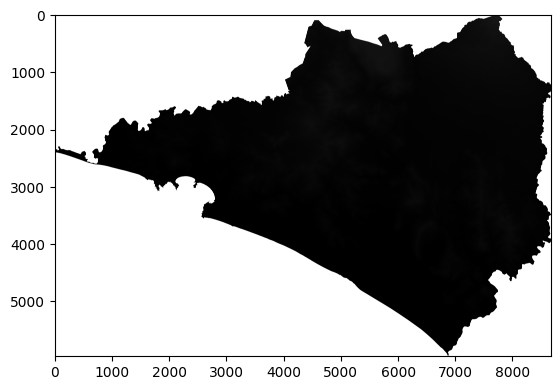

In [ ]:
plt.imshow(CEM.read(1), cmap='gray')

# Calculos

In [ ]:
poi.head()

,id,Lugar,geometry
0,1,UTEM,POINT (-11612417.240 2171359.647)
1,2,Campus El Naranjo UDC,POINT (-11621600.786 2169531.808)
2,3,Campus Tecomán UDC,POINT (-11565874.664 2148973.488)
3,4,Campus Coquimatlán UDC,POINT (-11555337.163 2179990.718)
4,5,Campus central UDC,POINT (-11543729.727 2184312.478)


In [ ]:
gdf_emisores.head()

,nra,nombre,scian,descripción scian,sector,clave\nambiental,subsector,principal actividad productiva,coordenada\nutm x,coordenada\nutm y,...,núm. ext,núm. int,colonia,localidad,estado,municipio,c.p.,lon,lat,geometry
645,cfead0600721,"comisión federal de electricidad,comision fede...",221110,"generación, transmisión y distribución de ener...",generación de energia electrica,ad,generacion y transmision de energia electrica,generación de energía electrica,571722.2798,2.103459e+06,...,s/n,s/n,colonia ejido de campos,manzanillo,colima,manzanillo,28809,-104.318333,19.022500,POINT (-11612663.747 2157585.105)
649,cfem90600711,"comisión federal de electricidad,terminal de g...",493111,almacenes generales de depósito,petroleo y petroquimica,m9,almacenamiento y distribucion de productos der...,otros servicios de almacenamiento con instalac...,577962.4898,2.102091e+06,...,s/n,,colonia campos,manzanillo,colima,manzanillo,28809,-104.259167,19.009722,POINT (-11606077.344 2156080.583)
713,cmb0600800009,consorcio minero benito juarez peña colorada s...,212210,minería de hierro,metalurgica (incluye la siderurgica),11,mineria de hierro,"exploración, explotación y beneficio de minera...",595263.3485,2.143837e+06,...,s/n,,colonia minatitlan,minatitlan,colima,minatitlan,28750,-104.092778,19.386389,POINT (-11587555.017 2200480.190)
714,cmb110600711,consorcio minero benito juarez peña colorada s...,212210,minería de hierro,metalurgica (incluye la siderurgica),11,mineria de hierro,"exploración, explotación y beneficio de minera...",575513.9065,2.110125e+06,...,1000,,colonia tapeixtles,manzanillo,colima,manzanillo,28876,-104.281944,19.082500,POINT (-11608612.954 2164651.365)
721,cma0600700006,"contecon manzanillo s.a. de c.v.,contecon manz...",493190,otros servicios de almacenamiento con instalac...,otros,zu,"almacen de materiales, productos y otros",terminal porturia de uso público especializada...,573219.9348,2.110144e+06,...,s/n,,puerto 1a sección tec ii zona norte,manzanillo,colima,manzanillo,28210,-104.303889,19.082778,POINT (-11611055.799 2164684.085)


In [ ]:
gdf_emisores
poi
vialidades
CEM

<open DatasetReader name='data/CEM_COLIMA/Colima_r15m.tif' mode='r'>

## distancia respecto a la ubicación de las fuentes puntuales de emisión

In [ ]:
distances = pd.DataFrame(columns=["emisor", "poi", "distance"])
for i, poi_i in poi.iterrows():
  for j, emisor_j in gdf_emisores.iterrows():
    # compute distance between emisor_j and poi_i
    dist = emisor_j.geometry.distance(poi_i.geometry)
    # append distance to distances dataframe
    df = {"emisor": emisor_j["nombre"], "poi": poi_i["Lugar"], "distance": dist}
    distances = pd.concat([distances, pd.DataFrame(df, index=[0])], ignore_index=True)
distances    


# keep the lowest distance for each poi
#distances2 = distances.groupby("poi").min().reset_index()
#distances2

,emisor,poi,distance
0,"comisión federal de electricidad,comision fede...",UTEM,13776.747794
1,"comisión federal de electricidad,terminal de g...",UTEM,16542.190943
2,consorcio minero benito juarez peña colorada s...,UTEM,38290.156744
3,consorcio minero benito juarez peña colorada s...,UTEM,7711.914654
4,"contecon manzanillo s.a. de c.v.,contecon manz...",UTEM,6812.976059
...,...,...,...
268,"marindustrias s. a. de c. v.,tuny",IMSS 3,39729.905614
269,operadora de la cuenca del pacífico s.a. de c....,IMSS 3,39717.576312
270,"terminal de servicios hazesa s.a. de c.v.,term...",IMSS 3,38821.908673
271,"usg mexico, s.a de c.v,usg mexico, s.a. de c.v...",IMSS 3,9070.832621


In [ ]:
distances = pd.DataFrame(columns=["emisor", "poi", "distance"])
for i, poi_i in poi.iterrows():
  # create a buffer around poi_i with 10000 meters
  poi_ = gpd.GeoSeries(poi_i.geometry)
  buffer = poi_.buffer(10000)
  
  # select emisores that intersects with buffer
  emisores_j = gpd.GeoDataFrame(gdf_emisores[gdf_emisores.intersects(buffer.unary_union)])
  
  for j, emisor_j in emisores_j.iterrows():
    # compute distance between emisor_j and poi_i
    emisor_ = gpd.GeoSeries(emisor_j.geometry)
    dist = emisor_.geometry.distance(poi_.geometry)
    # append distance to distances dataframe
    df = {"emisor": emisor_j["nombre"], "poi": poi_i["Lugar"], "distance": dist}
    distances = pd.concat([distances, pd.DataFrame(df, index=[0])], ignore_index=True)
  
  
distances.head()

,emisor,poi,distance
0,consorcio minero benito juarez peña colorada s...,UTEM,7711.914654
1,"contecon manzanillo s.a. de c.v.,contecon manz...",UTEM,6812.976059
2,"hotel las hadas resorts s.a. de c.v.,las hadas",UTEM,5766.586838
3,"impala terminals mexico, s.a. de c.v.,impala",UTEM,7480.134838
4,"marindustrias s. a. de c. v.,tuny",UTEM,7426.017245


In [ ]:
lowest_distances = pd.DataFrame(columns=["poi", "emisor", "distance"])

for i, poi_i in distances.groupby("poi"):
  print(i)
  poi_i = poi_i[poi_i["distance"] == poi_i["distance"].min()]
  lowest_distances = pd.concat([lowest_distances, poi_i], ignore_index=True)
  
lowest_distances

Campus Coquimatlán UDC
Campus El Naranjo UDC
Campus Norte UDC
Campus Tecomán UDC
Campus Villa de Álvarez UDC
Campus central UDC
IMSS 1
IMSS 10
IMSS 17
IMSS 19
IMSS 3
IMSS 6
UTEM


,poi,emisor,distance
0,Campus Coquimatlán UDC,"ecosistema de colima s.a. de c.v.,",4266.020239
1,Campus El Naranjo UDC,"hotel las hadas resorts s.a. de c.v.,las hadas",6209.447338
2,Campus Norte UDC,"embotelladora de colima sa de cv,coca cola de ...",4482.509771
3,Campus Tecomán UDC,"las encinas s.a. de c.v.,las encinas, s.a. de ...",1642.761383
4,Campus Villa de Álvarez UDC,"embotelladora de colima sa de cv,coca cola de ...",5350.423014
5,Campus central UDC,"embotelladora de colima sa de cv,coca cola de ...",2570.777333
6,IMSS 1,"embotelladora de colima sa de cv,coca cola de ...",7221.059096
7,IMSS 10,"hotel las hadas resorts s.a. de c.v.,las hadas",1913.894241
8,IMSS 17,"marindustrias s. a. de c. v.,tuny",1101.505499
9,IMSS 19,"embotelladora de colima sa de cv,coca cola de ...",3071.831462


In [ ]:
# reclassify column POB_TOTAL in 10 classes, from 1 to 10 with beautiful labels
distances["aptitud"] = pd.qcut(distances["distance"], 10, labels=range(1,11))

# meters to kilometers
distances["distance"] = distances["distance"]/1000

# round distance to 1 decimal
distances["distance"] = distances["distance"].round(1)

distances

,emisor,poi,distance,aptitud
0,consorcio minero benito juarez peña colorada s...,UTEM,7.7,8
1,"contecon manzanillo s.a. de c.v.,contecon manz...",UTEM,6.8,7
2,"hotel las hadas resorts s.a. de c.v.,las hadas",UTEM,5.8,5
3,"impala terminals mexico, s.a. de c.v.,impala",UTEM,7.5,8
4,"marindustrias s. a. de c. v.,tuny",UTEM,7.4,7
5,operadora de la cuenca del pacífico s.a. de c....,UTEM,9.6,10
6,"terminal de servicios hazesa s.a. de c.v.,term...",UTEM,8.2,9
7,"hotel las hadas resorts s.a. de c.v.,las hadas",Campus El Naranjo UDC,6.2,6
8,"danisco mexicana, s.a. de c.v.,danisco",Campus Tecomán UDC,2.5,3
9,"geocycle méxico s.a. de c.v. ,geocycle mexico...",Campus Tecomán UDC,4.9,4


In [ ]:
lowest_distances = lowest_distances.merge(distances[["emisor", "poi", "distance", "aptitud"]], on=["emisor", "poi"], how="left")
lowest_distances

,poi,emisor,distance_x,distance_y,aptitud
0,Campus Coquimatlán UDC,"ecosistema de colima s.a. de c.v.,",4266.020239,4.3,4
1,Campus El Naranjo UDC,"hotel las hadas resorts s.a. de c.v.,las hadas",6209.447338,6.2,6
2,Campus Norte UDC,"embotelladora de colima sa de cv,coca cola de ...",4482.509771,4.5,4
3,Campus Tecomán UDC,"las encinas s.a. de c.v.,las encinas, s.a. de ...",1642.761383,1.6,2
4,Campus Villa de Álvarez UDC,"embotelladora de colima sa de cv,coca cola de ...",5350.423014,5.4,5
5,Campus central UDC,"embotelladora de colima sa de cv,coca cola de ...",2570.777333,2.6,3
6,IMSS 1,"embotelladora de colima sa de cv,coca cola de ...",7221.059096,7.2,7
7,IMSS 10,"hotel las hadas resorts s.a. de c.v.,las hadas",1913.894241,1.9,2
8,IMSS 17,"marindustrias s. a. de c. v.,tuny",1101.505499,1.1,1
9,IMSS 19,"embotelladora de colima sa de cv,coca cola de ...",3071.831462,3.1,3


In [ ]:
# show range of POB_TOTAL values for each class
ranges = distances["distance"].groupby(distances["aptitud"]).describe()

ranges.reset_index(inplace=True)

ranges["range"] = ranges["min"].astype(str) + " - " + ranges["max"].astype(str)
ranges = ranges[["aptitud", "range", "min"]]

ranges

,aptitud,range,min
0,1,0.8 - 1.6,0.8
1,2,1.6 - 1.9,1.6
2,3,2.5 - 3.7,2.5
3,4,4.1 - 4.9,4.1
4,5,5.4 - 5.8,5.4
5,6,6.0 - 6.3,6.0
6,7,6.4 - 7.4,6.4
7,8,7.5 - 7.8,7.5
8,9,8.2 - 9.1,8.2
9,10,9.1 - 9.9,9.1


In [ ]:
distances = gpd.GeoDataFrame(distances.merge(ranges, on="aptitud"))
distances['aptitud'] = distances['aptitud'].astype(int)
distances.sort_values(by="aptitud", inplace=True)
distances.head()

,emisor,poi,distance,aptitud,range,min
43,"ingenio quesería sa de cv,",IMSS 6,0.8,1,0.8 - 1.6,0.8
41,"impala terminals mexico, s.a. de c.v.,impala",IMSS 17,1.3,1,0.8 - 1.6,0.8
40,"contecon manzanillo s.a. de c.v.,contecon manz...",IMSS 17,1.5,1,0.8 - 1.6,0.8
39,consorcio minero benito juarez peña colorada s...,IMSS 17,1.6,1,0.8 - 1.6,0.8
42,"marindustrias s. a. de c. v.,tuny",IMSS 17,1.1,1,0.8 - 1.6,0.8


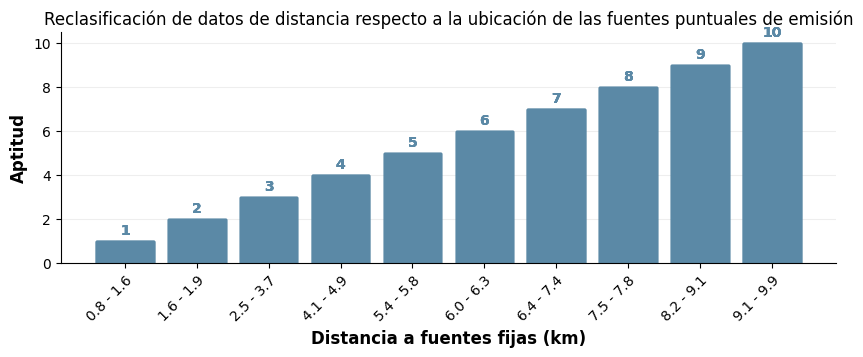

In [ ]:
fig, ax = plt.subplots( figsize=(10,3))
plt.rc('font', family='Open Sans')

bars = ax.bar(x=distances["range"], height=distances["aptitud"], color="#5B89A6")

# Add text annotations to the top of the bars.
# round corners of bars

bar_color = bars[0].get_facecolor()
for bar in bars:
  bar.set_edgecolor(bar_color)
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )
  
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# rotate xtick labels 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Reclasificación de datos de distancia respecto a la ubicación de las fuentes puntuales de emisión")
ax.set_xlabel("Distancia a fuentes fijas (km)", fontsize=12, fontweight="bold")
ax.set_ylabel("Aptitud", fontsize=12, fontweight="bold")
sns.despine()

plt.show()

In [ ]:
poi_agebs.head()

,id,Lugar,geometry,index_right,CVEGEO,aptitud_densidad
0,1,UTEM,POINT (-11612417.240 2171359.647),376.0,0600700011740,2.0
1,2,Campus El Naranjo UDC,POINT (-11621600.786 2169531.808),NaN,NaN,NaN
2,3,Campus Tecomán UDC,POINT (-11565874.664 2148973.488),130.0,0600900110408,7.0
3,4,Campus Coquimatlán UDC,POINT (-11555337.163 2179990.718),413.0,0600400010100,9.0
4,5,Campus central UDC,POINT (-11543729.727 2184312.478),109.0,0600200010021,7.0


In [ ]:
lowest_distances

,poi,emisor,distance_x,distance_y,aptitud
0,Campus Coquimatlán UDC,"ecosistema de colima s.a. de c.v.,",4266.020239,4.3,4
1,Campus El Naranjo UDC,"hotel las hadas resorts s.a. de c.v.,las hadas",6209.447338,6.2,6
2,Campus Norte UDC,"embotelladora de colima sa de cv,coca cola de ...",4482.509771,4.5,4
3,Campus Tecomán UDC,"las encinas s.a. de c.v.,las encinas, s.a. de ...",1642.761383,1.6,2
4,Campus Villa de Álvarez UDC,"embotelladora de colima sa de cv,coca cola de ...",5350.423014,5.4,5
5,Campus central UDC,"embotelladora de colima sa de cv,coca cola de ...",2570.777333,2.6,3
6,IMSS 1,"embotelladora de colima sa de cv,coca cola de ...",7221.059096,7.2,7
7,IMSS 10,"hotel las hadas resorts s.a. de c.v.,las hadas",1913.894241,1.9,2
8,IMSS 17,"marindustrias s. a. de c. v.,tuny",1101.505499,1.1,1
9,IMSS 19,"embotelladora de colima sa de cv,coca cola de ...",3071.831462,3.1,3


In [ ]:


lowest_distances = lowest_distances[["poi",  "aptitud"]]
lowest_distances.rename(columns={"poi": "Lugar", 'aptitud':'aptitud_fuentes'}, inplace=True)
lowest_distances.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_30144\170406394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowest_distances.rename(columns={"poi": "Lugar", 'aptitud':'aptitud_fuentes'}, inplace=True)


,Lugar,aptitud_fuentes
0,Campus Coquimatlán UDC,4
1,Campus El Naranjo UDC,6
2,Campus Norte UDC,4
3,Campus Tecomán UDC,2
4,Campus Villa de Álvarez UDC,5


In [ ]:
poi_agebs = poi_agebs.merge(lowest_distances, on="Lugar", how="left")
poi_agebs

,id,Lugar,geometry,index_right,CVEGEO,aptitud_densidad,aptitud_fuentes
0,1,UTEM,POINT (-11612417.240 2171359.647),376.0,0600700011740,2.0,5
1,2,Campus El Naranjo UDC,POINT (-11621600.786 2169531.808),NaN,NaN,NaN,6
2,3,Campus Tecomán UDC,POINT (-11565874.664 2148973.488),130.0,0600900110408,7.0,2
3,4,Campus Coquimatlán UDC,POINT (-11555337.163 2179990.718),413.0,0600400010100,9.0,4
4,5,Campus central UDC,POINT (-11543729.727 2184312.478),109.0,0600200010021,7.0,3
5,5,Campus Norte UDC,POINT (-11542489.380 2185787.044),251.0,0600200011388,1.0,4
6,6,Campus Villa de Álvarez UDC,POINT (-11548530.040 2186151.989),187.0,0601000011318,5.0,5
7,7,IMSS 17,POINT (-11609880.199 2165553.681),24.0,0600700010564,6.0,1
8,8,IMSS 10,POINT (-11614177.166 2167416.543),121.0,0600700011543,7.0,2
9,9,IMSS 1,POINT (-11550538.533 2186776.443),398.0,0601000011163,2.0,7


## distancia respecto a la ubicación de vialidades

In [ ]:
vialidades

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,060010001,06,001,0001,00198,00005,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574231.318 2146685.023, -115742..."
1,060010001,06,001,0001,00201,00003,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574105.505 2146631.207, -115740..."
2,060010001,06,001,0001,00048,00002,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574193.041 2148372.197, -115742..."
3,060010001,06,001,0001,00371,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574120.242 2148411.020, -115741..."
4,060010001,06,001,0001,00370,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (-11574817.697 2147114.506, -115748..."
...,...,...,...,...,...,...,...,...,...,...,...,...
45261,060100001,06,010,0001,01798,00007,Piramide de Soser,Calle,Un sentido,1,Urbana,"LINESTRING (-11551797.151 2183256.794, -115518..."
45262,060100001,06,010,0001,01798,00008,Piramide de Soser,Calle,Un sentido,1,Urbana,"LINESTRING (-11551777.070 2183293.799, -115517..."
45263,060100001,06,010,0001,01798,00009,Piramide de Soser,Calle,Un sentido,1,Urbana,"LINESTRING (-11551754.026 2183336.263, -115517..."
45264,060100001,06,010,0001,01798,00010,Piramide de Soser,Calle,Un sentido,1,Urbana,"LINESTRING (-11551714.134 2183409.775, -115517..."


In [ ]:
distances_vialidades = pd.DataFrame(columns=["vial", "poi", "distance"])
for i, poi_i in poi.iterrows():
  # create a buffer around poi_i with 10000 meters
  poi_ = gpd.GeoSeries(poi_i.geometry)
  buffer = poi_.buffer(1000)
  
  # select emisores that intersects with buffer
  filter_j = gpd.GeoDataFrame(vialidades[vialidades.intersects(buffer.unary_union)])
  for j, vial_j in filter_j.iterrows():
    # compute distance between vial_j and poi_i
    vial_ = gpd.GeoSeries(vial_j.geometry)
    dist = vial_.geometry.distance(poi_.geometry)
    # append distance to distances dataframe
    df = {"vial": vial_j["NOMVIAL"], "poi": poi_i["Lugar"], "distance": dist}
    distances_vialidades = pd.concat([distances_vialidades, pd.DataFrame(df, index=[0])], ignore_index=True)
  
  
distances_vialidades.head() 

,vial,poi,distance
0,Las Palmas,UTEM,936.094082
1,Las Palmas,UTEM,827.368297
2,Ficus,UTEM,663.144709
3,Primavera,UTEM,528.949776
4,Encino,UTEM,887.583964


In [ ]:
lowest_distances_vial = pd.DataFrame(columns=["poi", "vial", "distance"])

for i, poi_i in distances_vialidades.groupby("poi"):
  
  poi_i = poi_i[poi_i["distance"] == poi_i["distance"].min()]
  lowest_distances_vial = pd.concat([lowest_distances_vial, poi_i], ignore_index=True)
  
lowest_distances_vial

,poi,vial,distance
0,Campus Coquimatlán UDC,Ninguno,212.110510
1,Campus El Naranjo UDC,Del Paraíso,6.698059
2,Campus Norte UDC,Ninguno,93.173644
3,Campus Tecomán UDC,Álvaro Obregón,68.963279
4,Campus Villa de Álvarez UDC,Estado de México,101.887726
5,Campus central UDC,Universidad,161.162625
6,IMSS 1,Laurel de Indias,45.829418
7,IMSS 10,Hermanos Chávez Palacios,75.881273
8,IMSS 17,Los Pinos,34.414998
9,IMSS 19,Francisco Javier Mina,27.745624


In [ ]:
# reclassify column POB_TOTAL in 10 classes, from 1 to 10 with beautiful labels
distances_vialidades["aptitud"] = pd.qcut(distances_vialidades["distance"], 10, labels=range(1,11))

# meters to kilometers
distances_vialidades["distance"] = distances_vialidades["distance"]/1000

# round distance to 1 decimal
distances_vialidades["distance"] = distances_vialidades["distance"].round(1)

In [ ]:
# show range of POB_TOTAL values for each class
ranges = distances_vialidades["distance"].groupby(distances_vialidades["aptitud"]).describe()

ranges.reset_index(inplace=True)

ranges["range"] = ranges["min"].astype(str) + " - " + ranges["max"].astype(str)
ranges = ranges[["aptitud", "range", "min"]]

ranges

,aptitud,range,min
0,1,0.0 - 0.3,0.0
1,2,0.3 - 0.4,0.3
2,3,0.4 - 0.5,0.4
3,4,0.5 - 0.6,0.5
4,5,0.6 - 0.7,0.6
5,6,0.7 - 0.8,0.7
6,7,0.8 - 0.8,0.8
7,8,0.8 - 0.9,0.8
8,9,0.9 - 0.9,0.9
9,10,0.9 - 1.0,0.9


In [ ]:
distances_vialidades = gpd.GeoDataFrame(distances_vialidades.merge(ranges, on="aptitud"))
distances_vialidades['aptitud'] = distances_vialidades['aptitud'].astype(int)
distances_vialidades.sort_values(by="aptitud", inplace=True)
distances_vialidades.head()

,vial,poi,distance,aptitud,range,min
2800,De la Almeja,Campus El Naranjo UDC,0.0,1,0.0 - 0.3,0.0
3181,Alfonso Rolón Michel,IMSS 1,0.1,1,0.0 - 0.3,0.0
3180,Alfonso Rolón Michel,IMSS 1,0.2,1,0.0 - 0.3,0.0
3179,Alfonso Rolón Michel,IMSS 1,0.2,1,0.0 - 0.3,0.0
3178,Alfonso Rolón Michel,IMSS 1,0.2,1,0.0 - 0.3,0.0


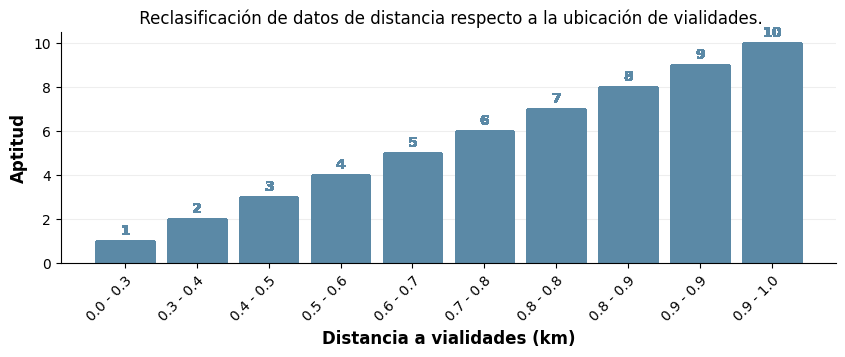

In [ ]:
fig, ax = plt.subplots( figsize=(10,3))
plt.rc('font', family='Open Sans')

bars = ax.bar(x=distances_vialidades["range"], height=distances_vialidades["aptitud"], color="#5B89A6")

# Add text annotations to the top of the bars.
# round corners of bars

bar_color = bars[0].get_facecolor()
for bar in bars:
  bar.set_edgecolor(bar_color)
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )
  
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# rotate xtick labels 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title(" Reclasificación de datos de distancia respecto a la ubicación de vialidades.")
ax.set_xlabel("Distancia a vialidades (km)", fontsize=12, fontweight="bold")
ax.set_ylabel("Aptitud", fontsize=12, fontweight="bold")
sns.despine()

plt.show()

In [ ]:
lowest_distances_vial.head()

,poi,vial,distance
0,Campus Coquimatlán UDC,Ninguno,212.110510
1,Campus El Naranjo UDC,Del Paraíso,6.698059
2,Campus Norte UDC,Ninguno,93.173644
3,Campus Tecomán UDC,Álvaro Obregón,68.963279
4,Campus Villa de Álvarez UDC,Estado de México,101.887726


In [ ]:
distances_vialidades.head()

,vial,poi,distance,aptitud,range,min
2800,De la Almeja,Campus El Naranjo UDC,0.0,1,0.0 - 0.3,0.0
3181,Alfonso Rolón Michel,IMSS 1,0.1,1,0.0 - 0.3,0.0
3180,Alfonso Rolón Michel,IMSS 1,0.2,1,0.0 - 0.3,0.0
3179,Alfonso Rolón Michel,IMSS 1,0.2,1,0.0 - 0.3,0.0
3178,Alfonso Rolón Michel,IMSS 1,0.2,1,0.0 - 0.3,0.0


In [ ]:
lowest_distances_vial = lowest_distances_vial.merge(distances_vialidades, on=["vial","poi"], how="left").drop_duplicates(subset=["vial","poi"])
lowest_distances_vial = lowest_distances_vial[["poi", "aptitud"]]
lowest_distances_vial.rename(columns={"poi": "Lugar", 'aptitud':'aptitud_vialidades'}, inplace=True)

In [ ]:
poi_agebs.head()

,id,Lugar,geometry,index_right,CVEGEO,aptitud_densidad,aptitud_fuentes
0,1,UTEM,POINT (-11612417.240 2171359.647),376.0,0600700011740,2.0,5
1,2,Campus El Naranjo UDC,POINT (-11621600.786 2169531.808),NaN,NaN,NaN,6
2,3,Campus Tecomán UDC,POINT (-11565874.664 2148973.488),130.0,0600900110408,7.0,2
3,4,Campus Coquimatlán UDC,POINT (-11555337.163 2179990.718),413.0,0600400010100,9.0,4
4,5,Campus central UDC,POINT (-11543729.727 2184312.478),109.0,0600200010021,7.0,3


In [ ]:
poi_agebs = poi_agebs.merge(lowest_distances_vial, on="Lugar", how="left")

In [ ]:
poi_agebs['aptitud_fuentes'] = poi_agebs['aptitud_fuentes'].astype(int)


In [ ]:
poi_agebs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  13 non-null     int64   
 1   Lugar               13 non-null     object  
 2   geometry            13 non-null     geometry
 3   index_right         12 non-null     float64 
 4   CVEGEO              12 non-null     object  
 5   aptitud_densidad    12 non-null     float64 
 6   aptitud_fuentes     13 non-null     int32   
 7   aptitud_vialidades  13 non-null     int32   
dtypes: float64(2), geometry(1), int32(2), int64(1), object(2)
memory usage: 832.0+ bytes


In [ ]:
# save poi_agebs to gpkg
poi_agebs.to_file("data/RETC_2004-2020/poi_agebs.gpkg", driver="GPKG")

## slope

In [ ]:
# compute zonal statistics for each ageb
zonal_stats = gpd.sjoin(poi_agebs, agebs, how="left", op="intersects")

NameError: name 'agebs' is not defined

In [ ]:
slope = rasterio.open("data/CEM_COLIMA/slope_agebs.tiff")
slope = slope.read(1)
slope

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

In [ ]:
# replace -9999 values with nan
slope[slope == -9999] = np.nan

In [ ]:
slope

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
# categorize slope values in 10 classes from 1 to 10
slope = pd.qcut(slope.flatten(), 10, labels=range(1,11), duplicates="drop")
slope

ValueError: Bin labels must be one fewer than the number of bin edges

# Evaluación final

In [ ]:
POI = gpd.read_file("data/RETC_2004-2020/zonas_evaluacion_aptitudes.gpkg")
POI

,Lugar,aptitud_densidad,aptitud_fuentes,aptitud_vialidades,so2,o3,no2,hcho,co,slopeRepro,geometry
0,UTEM,2.0,5,1,0.00009,0.12028,0.00007,0.00017,0.03169,0.00000,POINT (-11612417.240 2171359.647)
1,Campus El Naranjo UDC,NaN,6,1,0.00007,0.12033,0.00006,0.00017,0.03189,0.00000,POINT (-11621600.786 2169531.808)
2,Campus Tecomán UDC,7.0,2,1,0.00009,0.12040,0.00006,0.00017,0.03177,0.00000,POINT (-11565874.664 2148973.488)
3,Campus Coquimatlán UDC,9.0,4,1,0.00010,0.12015,0.00006,0.00019,0.03118,89.95499,POINT (-11555337.163 2179990.718)
4,Campus central UDC,7.0,3,1,0.00009,0.11986,0.00007,0.00019,0.03118,89.98576,POINT (-11543729.727 2184312.478)
5,Campus Norte UDC,1.0,4,1,0.00010,0.11985,0.00006,0.00019,0.03111,89.98409,POINT (-11542489.380 2185787.044)
6,Campus Villa de Álvarez UDC,5.0,5,1,0.00009,0.12002,0.00007,0.00019,0.03124,0.00000,POINT (-11548530.040 2186151.989)
7,IMSS 17,6.0,1,1,0.00012,0.12033,0.00007,0.00017,0.03136,0.00000,POINT (-11609880.199 2165553.681)
8,IMSS 10,7.0,2,1,0.00009,0.12036,0.00007,0.00017,0.03175,89.99117,POINT (-11614177.166 2167416.543)
9,IMSS 1,2.0,7,1,0.00009,0.12008,0.00007,0.00019,0.03126,89.98499,POINT (-11550538.533 2186776.443)


## Load TIF files

In [ ]:
tiff_files = [
  'data/CEM_COLIMA\\co.tif',
  'data/CEM_COLIMA\\hcho.tif',
  'data/CEM_COLIMA\\no2.tif',
  'data/CEM_COLIMA\\o3.tif',
  'data/CEM_COLIMA\\so2.tif',
  'data/CEM_COLIMA\\slopeRepro.tif']
tiff_files

['data/CEM_COLIMA\\co.tif',
 'data/CEM_COLIMA\\hcho.tif',
 'data/CEM_COLIMA\\no2.tif',
 'data/CEM_COLIMA\\o3.tif',
 'data/CEM_COLIMA\\so2.tif',
 'data/CEM_COLIMA\\slopeRepro.tif']

In [ ]:
rasterio.open(tiff_files[-1]).read(1)

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

In [ ]:
for tiff in tiff_files:
  tif = rasterio.open(tiff)
  sustancia = tiff.split("\\")[-1].split(".")[0]
  print(sustancia)

    
    
  tif = tif.read(1)
  tif_flat = tif.flatten()
  tif_flat.sort()
  if sustancia == 'slopeRepro':
    # remove -9999 values
    tif_flat = tif_flat[tif_flat != -9999]
    
  cut_series, cut_intervals = pd.cut(tif_flat, 10, labels=range(1,11), retbins=True, duplicates="drop")
  for i, row in POI.iterrows():
    for j, val in enumerate(cut_intervals):
      if row[sustancia] < abs(val):
        if sustancia == 'slopeRepro':
          print(row[sustancia] , val, j)
        if j == 10:
          POI.loc[i, sustancia] = 1
          break
        POI.loc[i, sustancia] = 10-j
        break

co
hcho
no2
o3
so2
slopeRepro
0.0 -0.08999979400634765 0
0.0 -0.08999979400634765 0
0.0 -0.08999979400634765 0
89.95499 89.99979400634766 10
89.98576 89.99979400634766 10
89.98409 89.99979400634766 10
0.0 -0.08999979400634765 0
0.0 -0.08999979400634765 0
89.99117 89.99979400634766 10
89.98499 89.99979400634766 10
89.95499 89.99979400634766 10
89.99615 89.99979400634766 10
0.0 -0.08999979400634765 0


In [ ]:
cut_intervals

array([-0.08999979,  8.9999794 , 17.9999588 , 26.9999382 , 35.9999176 ,
       44.999897  , 53.9998764 , 62.9998558 , 71.99983521, 80.99981461,
       89.99979401])

In [ ]:
POI['aptitud'] = POI[POI.columns[1:-1]].sum(axis=1)

In [ ]:
POI.sort_values(by="aptitud", ascending=False, inplace=True)

In [ ]:
POI

,Lugar,aptitud_densidad,aptitud_fuentes,aptitud_vialidades,so2,o3,no2,hcho,co,slopeRepro,geometry,aptitud
12,IMSS 3,6.0,9,1,6.0,2.0,5.0,2.0,1.0,10.0,POINT (-11573664.275 2147549.284),42.0
1,Campus El Naranjo UDC,NaN,6,1,6.0,3.0,5.0,3.0,1.0,10.0,POINT (-11621600.786 2169531.808),35.0
2,Campus Tecomán UDC,7.0,2,1,4.0,2.0,5.0,3.0,1.0,10.0,POINT (-11565874.664 2148973.488),35.0
11,IMSS 6,7.0,1,1,6.0,5.0,5.0,4.0,4.0,1.0,POINT (-11529038.871 2200499.135),34.0
6,Campus Villa de Álvarez UDC,5.0,5,1,4.0,4.0,1.0,1.0,2.0,10.0,POINT (-11548530.040 2186151.989),33.0
0,UTEM,2.0,5,1,4.0,3.0,1.0,3.0,2.0,10.0,POINT (-11612417.240 2171359.647),31.0
3,Campus Coquimatlán UDC,9.0,4,1,4.0,3.0,5.0,1.0,2.0,1.0,POINT (-11555337.163 2179990.718),30.0
7,IMSS 17,6.0,1,1,3.0,3.0,1.0,3.0,2.0,10.0,POINT (-11609880.199 2165553.681),30.0
10,IMSS 19,5.0,3,1,6.0,4.0,1.0,2.0,2.0,1.0,POINT (-11547825.347 2183388.232),25.0
4,Campus central UDC,7.0,3,1,4.0,4.0,1.0,1.0,2.0,1.0,POINT (-11543729.727 2184312.478),24.0


0.0

In [ ]:
cut_intervals

array([-0.08999979,  8.9999794 , 17.9999588 , 26.9999382 , 35.9999176 ,
       44.999897  , 53.9998764 , 62.9998558 , 71.99983521, 80.99981461,
       89.99979401])

In [ ]:
tif_flat

array([ 0.      ,  0.      ,  0.      , ..., 89.999794, 89.999794,
       89.999794], dtype=float32)